# Pre-Processing and Training Data

## Remember

The purpose of this project is to build a predictive model for Economic index based on school demographics in NYC. This model will be used to provide guidance for NYC's education system plan and aim to decrease economic indexes by borough.








## The next step is to 

1. Load the data


2. Split the data 


3. Scale and ecode data if necessary


4. initiate the model 


5. Create the Pipeline


6. fit the pipeline


We are going to use PySpark Mlib

to train and prprocess our model.

We are also going to import the libraries we want to use first

In [1]:
import pyspark
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import category_encoders as e
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import keras
import keras.utils
from keras import utils as np_utils
import tensorflow as tf
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

2022-11-27 12:32:05.749424: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Initiate Spark

In [2]:
nyc_data_model = pd.read_csv('../data/nyc_data_modeling.csv')

In [3]:
spark = SparkSession.builder.master("local[1]") \
                    .appName('SparkByExamples.com') \
                    .config("spark.driver.bindAddress", "127.0.0.1") \
                    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/27 12:32:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
sc = spark.sparkContext
sc

<SparkContext master=local[1] appName=SparkByExamples.com>

In [5]:
#sc.stop()

In [6]:
print("Spark Version: {}".format(sc.version))

Spark Version: 3.3.1


In [7]:
print("Spark Version: {}".format(sc.pythonVer))

Spark Version: 3.9


In [8]:
print("Spark Version: {}".format(sc.master))

Spark Version: local[1]


# Load data

In [9]:
PATH = '../data/nyc_data_modeling.csv'

In [10]:
# Pandas

nyc_pandas = pd.read_csv(PATH).iloc[:,1:]

In [11]:
#Spark
nyc_spark = spark.read.csv(PATH, header=True, inferSchema=True)

PySpark makes no such inferences. By default, PySpark will treat the header as the first row and all columns as string variables. To prevent PySpark from making any false assumptions, the user must assign values to the header and inferSchema parameters.

In [12]:
nyc_pandas.head()

,Year,# Male,# Asian,# Black,# Hispanic,# Multi-Racial,# Native American,# White,# Missing Race/Ethnicity Data,# Students with Disabilities,# English Language Learners,Economic Need Index,Borough,District Number,Economic Support,Pre School,Elementary School,Middle School,High School
0,2016-17,95,14,51,105,3,1,4,0,51,12,88.2,Manhattan,1,Need Support,45,133,0,0
1,2017-18,91,20,52,110,1,1,6,0,49,8,89.0,Manhattan,1,Need Support,45,145,0,0
2,2018-19,89,24,48,95,0,1,6,0,39,8,88.8,Manhattan,1,Need Support,33,141,0,0
3,2019-20,96,27,56,96,0,2,9,0,46,17,86.7,Manhattan,1,Need Support,43,147,0,0
4,2020-21,92,26,53,102,1,0,11,0,43,21,85.6,Manhattan,1,Need Support,46,147,0,0


Since PySpark implements lazy execution, it requires a trigger that derives the results of any operation. In this case, the show function acts as the trigger, letting the user view the loaded dataset.

In [13]:
nyc_pandas.describe()

,# Male,# Asian,# Black,# Hispanic,# Multi-Racial,# Native American,# White,# Missing Race/Ethnicity Data,# Students with Disabilities,# English Language Learners,Economic Need Index,District Number,Pre School,Elementary School,Middle School,High School
count,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000
mean,301.697241,95.272113,149.827898,239.106009,6.453594,6.534300,86.237321,2.524376,122.522303,80.493620,73.083172,27.062820,60.735304,220.988439,127.866834,176.365034
std,252.467601,217.404728,166.121062,223.101691,12.272638,14.409499,180.892501,8.999338,97.894632,106.569319,20.205806,26.072237,75.858914,260.187174,266.269458,467.812553
min,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,162.000000,5.000000,41.000000,90.000000,1.000000,1.000000,6.000000,0.000000,67.000000,18.000000,63.300000,10.000000,0.000000,0.000000,0.000000,0.000000
50%,245.000000,17.000000,102.000000,181.000000,2.000000,3.000000,15.000000,0.000000,99.000000,44.000000,79.200000,19.000000,46.000000,153.000000,0.000000,0.000000
75%,359.000000,81.000000,192.000000,313.000000,7.000000,7.000000,78.000000,1.000000,146.000000,100.000000,88.600000,29.000000,104.000000,389.000000,187.000000,248.000000
max,3635.000000,3671.000000,1493.000000,2056.000000,181.000000,355.000000,3104.000000,234.000000,925.000000,1168.000000,95.000000,84.000000,1328.000000,1688.000000,2265.000000,6040.000000


In [14]:
nyc_spark.describe().show()

22/11/27 12:32:30 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Year, # Male, # Asian, # Black, # Hispanic, # Multi-Racial, # Native American, # White, # Missing Race/Ethnicity Data, # Students with Disabilities, # English Language Learners, Economic Need Index, Borough, District Number, Economic Support, Pre School, Elementary School, Middle School, High School
 Schema: _c0, Year, # Male, # Asian, # Black, # Hispanic, # Multi-Racial, # Native American, # White, # Missing Race/Ethnicity Data, # Students with Disabilities, # English Language Learners, Economic Need Index, Borough, District Number, Economic Support, Pre School, Elementary School, Middle School, High School
Expected: _c0 but found: 
CSV file: file:///Users/taehyun/Dropbox/Springboard/NYC_Capstone_project/NewYorkCity_Education/data/nyc_data_modeling.csv


+-------+-----------------+-------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------------------+----------------------------+---------------------------+-------------------+-------------+------------------+----------------+-----------------+------------------+------------------+------------------+
|summary|              _c0|   Year|            # Male|           # Asian|           # Black|        # Hispanic|    # Multi-Racial| # Native American|          # White|# Missing Race/Ethnicity Data|# Students with Disabilities|# English Language Learners|Economic Need Index|      Borough|   District Number|Economic Support|       Pre School| Elementary School|     Middle School|       High School|
+-------+-----------------+-------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------------------+---

There is a random column in spark dataframe. Let's get rid of it.

In [15]:
nyc_spark = nyc_spark.drop('_c0')

We can also get rid of the categorical column economic support since we can directly predit the economic need index and deteremine which category it fits. 

In [16]:
nyc_spark = nyc_spark.drop('Economic Support')

In [17]:
print(nyc_spark.printSchema())

root
 |-- Year: string (nullable = true)
 |-- # Male: integer (nullable = true)
 |-- # Asian: integer (nullable = true)
 |-- # Black: integer (nullable = true)
 |-- # Hispanic: integer (nullable = true)
 |-- # Multi-Racial: integer (nullable = true)
 |-- # Native American: integer (nullable = true)
 |-- # White: integer (nullable = true)
 |-- # Missing Race/Ethnicity Data: integer (nullable = true)
 |-- # Students with Disabilities: integer (nullable = true)
 |-- # English Language Learners: integer (nullable = true)
 |-- Economic Need Index: double (nullable = true)
 |-- Borough: string (nullable = true)
 |-- District Number: integer (nullable = true)
 |-- Pre School: integer (nullable = true)
 |-- Elementary School: integer (nullable = true)
 |-- Middle School: integer (nullable = true)
 |-- High School: integer (nullable = true)

None


In [18]:
columns_to_drop = ['Economic Support']
nyc_spark = nyc_spark.drop(*columns_to_drop)
nyc_pandas = nyc_pandas.drop(['Economic Support'], axis=1)

### String Indexer -> OHEncode

In [19]:
indexer = StringIndexer(inputCols = ['Borough','District Number','Year'], outputCols = ['Borough_label','District Number_label','Year_label'])
nyc_spark_index = indexer.fit(nyc_spark).transform(nyc_spark)

In [20]:
ohe_encoder = OneHotEncoder(inputCols = ['Borough_label','District Number_label','Year_label'], outputCols = ['Borough_ohe','District Number_ohe','Year_ohe'], dropLast = True)
ohe_encoder_index = ohe_encoder.fit(nyc_spark_index).transform(nyc_spark_index)

In [21]:
ohe_encoder_index.show()

+-------+------+-------+-------+----------+--------------+-----------------+-------+-----------------------------+----------------------------+---------------------------+-------------------+---------+---------------+----------+-----------------+-------------+-----------+-------------+---------------------+----------+-------------+-------------------+-------------+
|   Year|# Male|# Asian|# Black|# Hispanic|# Multi-Racial|# Native American|# White|# Missing Race/Ethnicity Data|# Students with Disabilities|# English Language Learners|Economic Need Index|  Borough|District Number|Pre School|Elementary School|Middle School|High School|Borough_label|District Number_label|Year_label|  Borough_ohe|District Number_ohe|     Year_ohe|
+-------+------+-------+-------+----------+--------------+-----------------+-------+-----------------------------+----------------------------+---------------------------+-------------------+---------+---------------+----------+-----------------+-------------+----

### Scale the Data

In [22]:
vec_assembler = VectorAssembler(inputCols = ['# Male', '# Asian', '# Black', '# Hispanic', '# Multi-Racial',
       '# Native American', '# White', '# Missing Race/Ethnicity Data',
       '# Students with Disabilities', '# English Language Learners', 'Pre School',
       'Elementary School', 'Middle School', 'High School','Borough_ohe','District Number_ohe','Year_ohe'], outputCol = 'feature')

vec_assemb = vec_assembler.transform(ohe_encoder_index)
vec_assemb

DataFrame[Year: string, # Male: int, # Asian: int, # Black: int, # Hispanic: int, # Multi-Racial: int, # Native American: int, # White: int, # Missing Race/Ethnicity Data: int, # Students with Disabilities: int, # English Language Learners: int, Economic Need Index: double, Borough: string, District Number: int, Pre School: int, Elementary School: int, Middle School: int, High School: int, Borough_label: double, District Number_label: double, Year_label: double, Borough_ohe: vector, District Number_ohe: vector, Year_ohe: vector, feature: vector]

In [23]:
from pyspark.ml.feature import StandardScaler
scaler =  StandardScaler().setInputCol('feature').setOutputCol("feature_scaled")
vec_scaled_train = scaler.fit(vec_assemb).transform(vec_assemb)

22/11/27 12:32:36 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## Split the data

In [24]:
(train_df, test_df) = vec_scaled_train.randomSplit([0.8, 0.2])

## Model 1. Linear Regression

The model I chose is linear Regression and I chose it since it is a classic regression model with linear algorithm. Simply all the calculation of the functions add up to the dependent variable.

I am going to use the following parameters and tune it.

1. elasticNetParam = 1.0
by setting it equal to 1.0, it means that it's lasso regression which is L1.

I chose L1 penalization over L2 because I have a lot of outliers in my data set. Since L1 takes the manhattan distance meaning it is penalizing the !absolute value! of the weights so it is more robust to outliers.

The down side of L1 would be the case when we have highly correlated features, the L1 norm would select only 1 of the features from the group of correlated features in an arbitrary nature so lasso regression also acts as a feature selector.

0.5 would be the mix of L1 and L2.

In general, Lasso regression (Linear Regression with L1 regularization) would produce a model that is highly interpretable, and only uses a subset of input features, thus reducing the complexity of the model.

2. MaxItr = 100,150,200,250
This has no reason. The higher the iteration, prone to overfit. 

3. regParam
This is unknown. We have to try multiple values


In [25]:
metric_list = []

In [26]:
linear_regressor = LinearRegression(featuresCol = 'feature_scaled', labelCol = 'Economic Need Index')

## Tune the model now

In [27]:
# alpha = 0 - penalty L2
paramGrid = (ParamGridBuilder()
               .addGrid(linear_regressor.maxIter, [100,150,200,250])
               .addGrid(linear_regressor.elasticNetParam, [0.1,0.5,1.0])
               .addGrid(linear_regressor.regParam, [0.3,0.6,0.9])
               .build())

In [28]:
evaluator = RegressionEvaluator(labelCol="Economic Need Index",
                                predictionCol="prediction",
                                metricName="rmse")

regressorcv = CrossValidator(estimator = linear_regressor,
                            estimatorParamMaps = paramGrid,
                            evaluator = evaluator,
                            numFolds = 5)

linear_regression_cv = regressorcv.fit(train_df)

22/11/27 12:32:39 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/11/27 12:32:39 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


## Evaluate¶

In [29]:
lr_regressor_predictions = linear_regression_cv.transform(test_df)
print('RMSE:', evaluator.evaluate(lr_regressor_predictions))
metric_list.append(evaluator.evaluate(lr_regressor_predictions))

RMSE: 10.468420136979878


### Extra Notes about preprocessing

Sparks one hot encoder: have to convert String to index and then convert again to one hot encode.

sklearns one hot encoder: converts directly to index from String

so basically, the above solution is splitting the data after encoding and scaling and the bottom solution is I split the data first and encoded. According to the evaluation metrics, the score doesn't have a difference at all. Therefore, I prefer using the top method which contains less code. 

Steps:
Encode -> Scale(Normalize) -> Split -> Model -> Evaluate

### Encoding

In [30]:
#from pyspark.ml.feature import OneHotEncoder
#from pyspark.ml.feature import StringIndexer
#from pyspark.ml.feature import VectorAssembler
#from pyspark.ml.feature import StandardScaler

#indexer = StringIndexer(inputCols = ['Borough','District Number','Year'], outputCols = ['Borough_label','District Number_label','Year_label'])
#label_df_train = indexer.fit(train_df).transform(train_df)
#label_df_test = indexer.fit(test_df).transform(test_df)

In [31]:
#ohe_encoder = OneHotEncoder(inputCols = ['Borough_label','District Number_label','Year_label'], outputCols = ['Borough_ohe','District Number_ohe','Year_ohe'], dropLast = True)
#encoding_df_train = ohe_encoder.fit(label_df_train).transform(label_df_train)
#encoding_df_test = ohe_encoder.fit(label_df_test).transform(label_df_test)

### Scaling

In spark, when we scale, we have to perform vectorAssembler to perform Feature Vectorization meaning all the columns should be vectorized. 

In [32]:
#vec_assembler = VectorAssembler(inputCols = ['# Male', '# Asian', '# Black', '# Hispanic', '# Multi-Racial',
       #'# Native American', '# White', '# Missing Race/Ethnicity Data',
       #'# Students with Disabilities', '# English Language Learners', 'Pre School',
       #'Elementary School', 'Middle School', 'High School','Borough_ohe','District Number_ohe','Year_ohe'], outputCol = 'feature')

#vec_assemb_train = vec_assembler.transform(encoding_df_train)
#vec_assemb_test = vec_assembler.transform(encoding_df_test)

In [33]:
#scaler = StandardScaler(inputCol='feature', outputCol='feature_scaled', withMean=True, withStd=True)
#vec_scaled_train = scaler.fit(vec_assemb).transform(vec_assemb_train)
#vec_scaled_test = scaler.fit(vec_assemb).transform(vec_assemb_test)

### Create Model

In [34]:
#from pyspark.ml.regression import LinearRegression

#regressor = LinearRegression(featuresCol = 'feature_scaled', labelCol = 'Economic Need Index')

In [35]:
#linear_model = regressor.fit(vec_scaled_train)

In [36]:
#print("Coefficients: " + str(linear_model.coefficients))
#print("\nIntercept: " + str(linear_model.intercept))
#trainSummary = linear_model.summary
#print("RMSE: %f" % trainSummary.rootMeanSquaredError)
#print("\nr2: %f" % trainSummary.r2)

In [37]:
#pred = linear_model.evaluate(vec_scaled_test)
#pred.predictions.toPandas().iloc[:,10:].head()

In [38]:
#print('‘MAE for test set:’', pred.meanAbsoluteError)
#print('MSE for test set:', pred.meanSquaredError)
#print('RMSE for test set:', pred.rootMeanSquaredError)
#print('R2-Score for test set:', pred.r2)

### Model 2: Decision tree Regression

I chose Decision tree Regression because it is

In [39]:
regressor = DecisionTreeRegressor(featuresCol = 'feature_scaled', labelCol = 'Economic Need Index')

## Binning feature values

Increasing maxBins allows the algorithm to consider more split candidates and make fine-grained split decisions. However, it also increases computation and communication.

Note that the maxBins parameter must be at least the maximum number of categories M for any categorical feature.

### Max depth

Increasing the depth leads to overfitting since it increases its complexity. 

## Tuning the model

In [40]:
paramGrid = (ParamGridBuilder()
               .addGrid(regressor.maxDepth, [2,5,10,2,30])
               .addGrid(regressor.maxBins, [10,20,40,80,100])
               .build())

### Evaluation

In [41]:
evaluator = RegressionEvaluator(labelCol="Economic Need Index",
                                predictionCol="prediction",
                                metricName="rmse")

regressorcv = CrossValidator(estimator = regressor,
                            estimatorParamMaps = paramGrid,
                            evaluator = evaluator,
                            numFolds = 5)


In [42]:
tree_regressor_model = regressorcv.fit(train_df)

22/11/27 12:34:18 WARN DAGScheduler: Broadcasting large task binary with size 1109.9 KiB
22/11/27 12:34:18 WARN DAGScheduler: Broadcasting large task binary with size 1227.1 KiB
22/11/27 12:34:19 WARN DAGScheduler: Broadcasting large task binary with size 1329.6 KiB
22/11/27 12:34:19 WARN DAGScheduler: Broadcasting large task binary with size 1415.8 KiB
22/11/27 12:34:19 WARN DAGScheduler: Broadcasting large task binary with size 1489.9 KiB
22/11/27 12:34:19 WARN DAGScheduler: Broadcasting large task binary with size 1550.7 KiB
22/11/27 12:34:20 WARN DAGScheduler: Broadcasting large task binary with size 1596.9 KiB
22/11/27 12:34:20 WARN DAGScheduler: Broadcasting large task binary with size 1632.1 KiB
22/11/27 12:34:20 WARN DAGScheduler: Broadcasting large task binary with size 1657.2 KiB
22/11/27 12:34:20 WARN DAGScheduler: Broadcasting large task binary with size 1678.2 KiB
22/11/27 12:34:20 WARN DAGScheduler: Broadcasting large task binary with size 1691.6 KiB
22/11/27 12:34:21 WAR

22/11/27 12:34:49 WARN DAGScheduler: Broadcasting large task binary with size 1027.7 KiB
22/11/27 12:34:49 WARN DAGScheduler: Broadcasting large task binary with size 1150.6 KiB
22/11/27 12:34:50 WARN DAGScheduler: Broadcasting large task binary with size 1258.7 KiB
22/11/27 12:34:51 WARN DAGScheduler: Broadcasting large task binary with size 1357.8 KiB
22/11/27 12:34:51 WARN DAGScheduler: Broadcasting large task binary with size 1446.9 KiB
22/11/27 12:34:52 WARN DAGScheduler: Broadcasting large task binary with size 1520.4 KiB
22/11/27 12:34:52 WARN DAGScheduler: Broadcasting large task binary with size 1578.8 KiB
22/11/27 12:34:53 WARN DAGScheduler: Broadcasting large task binary with size 1620.5 KiB
22/11/27 12:34:53 WARN DAGScheduler: Broadcasting large task binary with size 1645.0 KiB
22/11/27 12:34:53 WARN DAGScheduler: Broadcasting large task binary with size 1660.2 KiB
22/11/27 12:34:53 WARN DAGScheduler: Broadcasting large task binary with size 1670.8 KiB
22/11/27 12:34:53 WAR

22/11/27 12:36:36 WARN DAGScheduler: Broadcasting large task binary with size 1023.8 KiB
22/11/27 12:36:36 WARN DAGScheduler: Broadcasting large task binary with size 1131.6 KiB
22/11/27 12:36:37 WARN DAGScheduler: Broadcasting large task binary with size 1226.0 KiB
22/11/27 12:36:37 WARN DAGScheduler: Broadcasting large task binary with size 1311.9 KiB
22/11/27 12:36:38 WARN DAGScheduler: Broadcasting large task binary with size 1386.0 KiB
22/11/27 12:36:38 WARN DAGScheduler: Broadcasting large task binary with size 1452.5 KiB
22/11/27 12:36:39 WARN DAGScheduler: Broadcasting large task binary with size 1510.7 KiB
22/11/27 12:36:39 WARN DAGScheduler: Broadcasting large task binary with size 1562.0 KiB
22/11/27 12:36:39 WARN DAGScheduler: Broadcasting large task binary with size 1606.3 KiB
22/11/27 12:36:39 WARN DAGScheduler: Broadcasting large task binary with size 1641.7 KiB
22/11/27 12:36:40 WARN DAGScheduler: Broadcasting large task binary with size 1666.9 KiB
22/11/27 12:36:40 WAR

22/11/27 12:37:28 WARN DAGScheduler: Broadcasting large task binary with size 1028.8 KiB
22/11/27 12:37:29 WARN DAGScheduler: Broadcasting large task binary with size 1145.9 KiB
22/11/27 12:37:30 WARN DAGScheduler: Broadcasting large task binary with size 1249.5 KiB
22/11/27 12:37:30 WARN DAGScheduler: Broadcasting large task binary with size 1337.9 KiB
22/11/27 12:37:31 WARN DAGScheduler: Broadcasting large task binary with size 1415.8 KiB
22/11/27 12:37:31 WARN DAGScheduler: Broadcasting large task binary with size 1485.5 KiB
22/11/27 12:37:31 WARN DAGScheduler: Broadcasting large task binary with size 1537.3 KiB
22/11/27 12:37:32 WARN DAGScheduler: Broadcasting large task binary with size 1578.0 KiB
22/11/27 12:37:32 WARN DAGScheduler: Broadcasting large task binary with size 1612.8 KiB
22/11/27 12:37:32 WARN DAGScheduler: Broadcasting large task binary with size 1644.2 KiB
22/11/27 12:37:33 WARN DAGScheduler: Broadcasting large task binary with size 1669.8 KiB
22/11/27 12:37:33 WAR

In [43]:
regressor_predictions = tree_regressor_model.transform(test_df)
print('RMSE:', evaluator.evaluate(regressor_predictions))
metric_list.append(evaluator.evaluate(regressor_predictions))

RMSE: 8.378993717693337


## Model 3: Multilayer Perceptron

I am going to be using Keras for this. The reaason why i chose this model is to try out with the multi layer regression

This model is used for accuracy purposes sacrificing speed compared to the two above models. Since it performs better in large data than the normal linear regression and decision tree regressor, I will be using it. 

In [44]:
x = nyc_pandas.drop(['Economic Need Index'],axis=1)
y = nyc_pandas['Economic Need Index']

### Split the data

In [45]:
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size = 0.2, random_state= 42)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state= 40)

In [46]:
temp_columns = x_train.columns.tolist()

#index of desired column to move
index = x_train.columns.get_loc('Borough')
temp_columns = temp_columns[0:index]+temp_columns[index+1:]+temp_columns[index:index+1]

In [47]:
index = x_train.columns.get_loc('Year')

#Move to the last
temp_columns.pop(index)

'Year'

In [48]:
temp_columns.append('Year')

In [49]:
temp_columns

['# Male',
 '# Asian',
 '# Black',
 '# Hispanic',
 '# Multi-Racial',
 '# Native American',
 '# White',
 '# Missing Race/Ethnicity Data',
 '# Students with Disabilities',
 '# English Language Learners',
 'District Number',
 'Pre School',
 'Elementary School',
 'Middle School',
 'High School',
 'Borough',
 'Year']

In [50]:
index1 = temp_columns.index('District Number')

temp_columns.pop(index1)

'District Number'

In [51]:
temp_columns.append('District Number')

In [52]:
temp_columns

['# Male',
 '# Asian',
 '# Black',
 '# Hispanic',
 '# Multi-Racial',
 '# Native American',
 '# White',
 '# Missing Race/Ethnicity Data',
 '# Students with Disabilities',
 '# English Language Learners',
 'Pre School',
 'Elementary School',
 'Middle School',
 'High School',
 'Borough',
 'Year',
 'District Number']

In [53]:
x_train = x_train[temp_columns]
x_val = x_val[temp_columns]
x_test = x_test[temp_columns]

In [54]:
x_train

,# Male,# Asian,# Black,# Hispanic,# Multi-Racial,# Native American,# White,# Missing Race/Ethnicity Data,# Students with Disabilities,# English Language Learners,Pre School,Elementary School,Middle School,High School,Borough,Year,District Number
7891,230,14,93,174,0,20,7,0,307,98,1,0,66,241,Bronx,2020-21,75
1469,271,4,121,389,2,1,16,0,125,112,121,412,0,0,Bronx,2020-21,7
4089,75,8,91,23,1,0,10,0,41,27,0,0,133,0,Brooklyn,2018-19,17
3413,176,15,285,31,1,5,12,14,50,4,0,0,0,363,Brooklyn,2018-19,13
3235,262,4,133,319,2,6,6,1,150,60,0,0,0,471,Bronx,2018-19,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7839,367,117,81,210,5,6,64,0,483,207,93,235,97,58,Queens,2018-19,75
3603,330,26,143,485,1,6,44,14,132,32,0,0,0,719,Brooklyn,2020-21,14
5959,584,771,50,124,12,1,202,0,151,89,0,0,1160,0,Queens,2017-18,26
5426,625,681,7,486,1,8,36,0,183,357,203,1016,0,0,Queens,2017-18,24


### Encode

### x_train

In [55]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

encoder.fit(x_train[['Year','Borough','District Number']])

print(encoder.categories_)
encoded_x_train = encoder.transform(x_train[['Year','Borough','District Number']]).toarray()

print(encoder.get_feature_names_out(['Year','Borough','District Number']))
encoded_x_train = pd.DataFrame(encoded_x_train, columns = encoder.get_feature_names_out(['Year','Borough','District Number']))
encoded_x_train.head()

print(encoded_x_train.shape)

[array(['2016-17', '2017-18', '2018-19', '2019-20', '2020-21'],
      dtype=object), array(['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'],
      dtype=object), array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 75, 79,
       84])]
['Year_2016-17' 'Year_2017-18' 'Year_2018-19' 'Year_2019-20'
 'Year_2020-21' 'Borough_Bronx' 'Borough_Brooklyn' 'Borough_Manhattan'
 'Borough_Queens' 'Borough_Staten Island' 'District Number_1'
 'District Number_2' 'District Number_3' 'District Number_4'
 'District Number_5' 'District Number_6' 'District Number_7'
 'District Number_8' 'District Number_9' 'District Number_10'
 'District Number_11' 'District Number_12' 'District Number_13'
 'District Number_14' 'District Number_15' 'District Number_16'
 'District Number_17' 'District Number_18' 'District Number_19'
 'District Number_20' 'District Number_21' 'District Number_22'
 'District Number_23' 'Distr

### x_val

In [56]:
encoder = OneHotEncoder()
encoder.fit(x_val[['Year','Borough','District Number']])
print(encoder.categories_)
encoded_x_val = encoder.transform(x_val[['Year','Borough','District Number']]).toarray()
print(encoder.get_feature_names_out(['Year','Borough','District Number']))
encoded_x_val = pd.DataFrame(encoded_x_val, columns = encoder.get_feature_names_out(['Year','Borough','District Number']))
encoded_x_val.head()
print(encoded_x_val.shape)

[array(['2016-17', '2017-18', '2018-19', '2019-20', '2020-21'],
      dtype=object), array(['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'],
      dtype=object), array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 75, 79,
       84])]
['Year_2016-17' 'Year_2017-18' 'Year_2018-19' 'Year_2019-20'
 'Year_2020-21' 'Borough_Bronx' 'Borough_Brooklyn' 'Borough_Manhattan'
 'Borough_Queens' 'Borough_Staten Island' 'District Number_1'
 'District Number_2' 'District Number_3' 'District Number_4'
 'District Number_5' 'District Number_6' 'District Number_7'
 'District Number_8' 'District Number_9' 'District Number_10'
 'District Number_11' 'District Number_12' 'District Number_13'
 'District Number_14' 'District Number_15' 'District Number_16'
 'District Number_17' 'District Number_18' 'District Number_19'
 'District Number_20' 'District Number_21' 'District Number_22'
 'District Number_23' 'Distr

In [57]:
encoder = OneHotEncoder()
encoder.fit(x_test[['Year','Borough','District Number']])
print(encoder.categories_)
encoded_x_test = encoder.transform(x_test[['Year','Borough','District Number']]).toarray()
print(encoder.get_feature_names_out(['Year','Borough','District Number']))
encoded_x_test = pd.DataFrame(encoded_x_test, columns = encoder.get_feature_names_out(['Year','Borough','District Number']))
encoded_x_test.head()
print(encoded_x_test.shape)

[array(['2016-17', '2017-18', '2018-19', '2019-20', '2020-21'],
      dtype=object), array(['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'],
      dtype=object), array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 75, 79,
       84])]
['Year_2016-17' 'Year_2017-18' 'Year_2018-19' 'Year_2019-20'
 'Year_2020-21' 'Borough_Bronx' 'Borough_Brooklyn' 'Borough_Manhattan'
 'Borough_Queens' 'Borough_Staten Island' 'District Number_1'
 'District Number_2' 'District Number_3' 'District Number_4'
 'District Number_5' 'District Number_6' 'District Number_7'
 'District Number_8' 'District Number_9' 'District Number_10'
 'District Number_11' 'District Number_12' 'District Number_13'
 'District Number_14' 'District Number_15' 'District Number_16'
 'District Number_17' 'District Number_18' 'District Number_19'
 'District Number_20' 'District Number_21' 'District Number_22'
 'District Number_23' 'Distr

### Scale

In [58]:
from sklearn.preprocessing import StandardScaler
column_insert = x_train.loc[:,:'High School'].columns
sc = StandardScaler()
x_train_scaled = pd.DataFrame(sc.fit_transform(x_train.loc[:,:'High School']),columns = column_insert)
x_test_scaled = pd.DataFrame(sc.fit_transform(x_test.loc[:,:'High School']),columns = column_insert)
x_val_scaled = pd.DataFrame(sc.fit_transform(x_val.loc[:,:'High School']),columns=column_insert)

In [59]:
x_train_scaled.shape

(7335, 14)

In [60]:
x_test_scaled.shape

(1834, 14)

In [61]:
x_val_scaled.shape

(1834, 14)

In [62]:
print(x_train_scaled.index)
print(encoded_x_train.index)

RangeIndex(start=0, stop=7335, step=1)
RangeIndex(start=0, stop=7335, step=1)


In [63]:
print(x_val_scaled.index)
print(encoded_x_val.index)

RangeIndex(start=0, stop=1834, step=1)
RangeIndex(start=0, stop=1834, step=1)


In [64]:
print(x_test_scaled.index)
print(encoded_x_val.index)

RangeIndex(start=0, stop=1834, step=1)
RangeIndex(start=0, stop=1834, step=1)


In [65]:
final_df_x_train = pd.concat([encoded_x_train,x_train_scaled],axis=1)
final_df_x_val= pd.concat([encoded_x_val,x_val_scaled],axis=1)
final_df_x_test = pd.concat([encoded_x_test,x_test_scaled],axis=1)

### Initialize model

In [66]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation = 'relu', input_shape = final_df_x_train.shape[1:]),
    keras.layers.Dense(1)
])

model.compile(loss = 'mean_absolute_error', optimizer = 'sgd', metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(final_df_x_train,y_train, batch_size = 64, epochs= 50, validation_data=(final_df_x_val, y_val))

2022-11-27 12:38:29.050572: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
115/115 [==============================] - 1s 3ms/step - loss: 70.1203 - root_mean_squared_error: 72.9447 - val_loss: 64.9253 - val_root_mean_squared_error: 67.7333
Epoch 2/50
115/115 [==============================] - 0s 2ms/step - loss: 41.7865 - root_mean_squared_error: 48.2272 - val_loss: 11.3466 - val_root_mean_squared_error: 14.4603
Epoch 3/50
115/115 [==============================] - 0s 2ms/step - loss: 8.2787 - root_mean_squared_error: 11.4426 - val_loss: 7.3469 - val_root_mean_squared_error: 10.2763
Epoch 4/50
115/115 [==============================] - 0s 2ms/step - loss: 7.1929 - root_mean_squared_error: 10.1976 - val_loss: 6.9046 - val_root_mean_squared_error: 9.7458
Epoch 5/50
115/115 [==============================] - 0s 2ms/step - loss: 6.8794 - root_mean_squared_error: 9.7861 - val_loss: 6.7106 - val_root_mean_squared_error: 9.3970
Epoch 6/50
115/115 [==============================] - 0s 2ms/step - loss: 6.7012 - root_mean_squared_error: 9.5428 - val_loss: 6.

In [67]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

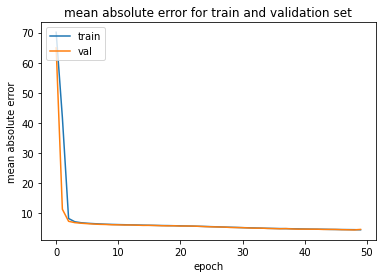

In [68]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('mean absolute error for train and validation set')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train','val'], loc = 'upper left')
plt.show()

I can see that my model is over fitting. 

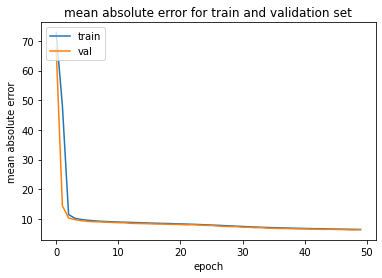

In [69]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('mean absolute error for train and validation set')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train','val'], loc = 'upper left')
plt.show()

I chose the activatioon function ReLU in the hidden layer. It is a commonly used activation function where if the input x is negative, then a value 0 is returned. 

We can penalize high errors with RMSE so we use rmse.

By analysis, we find that compared with ADAM, SGD is more locally unstable and is more likely to converge to the minima at the flat or asymmetric basins/valleys which often have better generalization performance over other type minima. So our results can explain the better generalization performance of SGD over ADAM. SO i didnt use adams

Source: https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/

In [70]:
# getting the metrics

def metrics_for_mlp():
    y_pred = model.predict(final_df_x_test).ravel()
    rmse = mean_squared_error(y_test, y_pred, squared = False)
    return rmse

In [71]:
metrics_for_mlp()

58/58 [==============================] - 0s 1ms/step


6.795657962502768

In [72]:
metric_list.append(round(6.78,2))

### Cat Boost

In [73]:
import optuna
from optuna.samplers import TPESampler
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

In [74]:
def cb_objective(trial):
    learning_rate = trial.suggest_float('learning_rate',0.01,0.2)
    n_estimators = trial.suggest_int('n_estimators',100,500)
    depth = trial.suggest_int('depth', 1,10)
    l2_leaf_reg = trial.suggest_int('l2_leaf_reg', 3,15)
    
    cb = CatBoostRegressor(learning_rate = learning_rate, 
                            n_estimators = n_estimators,
                            depth = depth, 
                            l2_leaf_reg= l2_leaf_reg, 
                            loss_function = 'RMSE')
    
    cb.fit(final_df_x_train, y_train)
    
    y_pred = cb.predict(final_df_x_val)
    
    return mean_squared_error(y_val, y_pred, squared=False)

study = optuna.create_study(direction = 'minimize')
study.optimize(cb_objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)
    

[I 2022-11-27 12:38:43,426] A new study created in memory with name: no-name-4f42d41b-a9df-4665-82ad-b3c499d4f311


0:	learn: 18.6476088	total: 79.7ms	remaining: 20.7s
1:	learn: 17.2710053	total: 83.1ms	remaining: 10.8s
2:	learn: 16.0119955	total: 86.9ms	remaining: 7.47s
3:	learn: 14.9715251	total: 90ms	remaining: 5.78s
4:	learn: 14.0093481	total: 93.2ms	remaining: 4.77s
5:	learn: 13.1703836	total: 96.3ms	remaining: 4.09s
6:	learn: 12.4567905	total: 99.4ms	remaining: 3.61s
7:	learn: 11.8093833	total: 102ms	remaining: 3.24s
8:	learn: 11.2088100	total: 106ms	remaining: 2.96s
9:	learn: 10.6766950	total: 109ms	remaining: 2.73s
10:	learn: 10.1955505	total: 112ms	remaining: 2.55s
11:	learn: 9.7867395	total: 116ms	remaining: 2.41s
12:	learn: 9.4074561	total: 120ms	remaining: 2.29s
13:	learn: 9.0770582	total: 125ms	remaining: 2.21s
14:	learn: 8.7521160	total: 128ms	remaining: 2.1s
15:	learn: 8.4848841	total: 131ms	remaining: 2.01s
16:	learn: 8.2432895	total: 135ms	remaining: 1.94s
17:	learn: 8.0383396	total: 138ms	remaining: 1.87s
18:	learn: 7.8281991	total: 142ms	remaining: 1.81s
19:	learn: 7.6418210	total

[I 2022-11-27 12:38:44,683] Trial 0 finished with value: 3.7160852378224036 and parameters: {'learning_rate': 0.11326915003832543, 'n_estimators': 261, 'depth': 7, 'l2_leaf_reg': 4}. Best is trial 0 with value: 3.7160852378224036.


247:	learn: 3.2063501	total: 1.02s	remaining: 53.3ms
248:	learn: 3.2004530	total: 1.02s	remaining: 49.2ms
249:	learn: 3.1935971	total: 1.02s	remaining: 45.1ms
250:	learn: 3.1893830	total: 1.03s	remaining: 41ms
251:	learn: 3.1838219	total: 1.03s	remaining: 36.9ms
252:	learn: 3.1811678	total: 1.04s	remaining: 32.8ms
253:	learn: 3.1762216	total: 1.04s	remaining: 28.7ms
254:	learn: 3.1722530	total: 1.04s	remaining: 24.6ms
255:	learn: 3.1681150	total: 1.05s	remaining: 20.5ms
256:	learn: 3.1644342	total: 1.05s	remaining: 16.4ms
257:	learn: 3.1587101	total: 1.05s	remaining: 12.3ms
258:	learn: 3.1527778	total: 1.06s	remaining: 8.17ms
259:	learn: 3.1490000	total: 1.06s	remaining: 4.09ms
260:	learn: 3.1422220	total: 1.07s	remaining: 0us
0:	learn: 19.9663119	total: 1.39ms	remaining: 252ms
1:	learn: 19.6846825	total: 3.07ms	remaining: 276ms
2:	learn: 19.4195109	total: 4.79ms	remaining: 286ms
3:	learn: 19.1569938	total: 5.99ms	remaining: 267ms
4:	learn: 18.9007067	total: 7.83ms	remaining: 277ms
5:	

[I 2022-11-27 12:38:45,001] Trial 1 finished with value: 8.53720012421331 and parameters: {'learning_rate': 0.026369053253337008, 'n_estimators': 182, 'depth': 2, 'l2_leaf_reg': 13}. Best is trial 0 with value: 3.7160852378224036.


57:	learn: 12.2355491	total: 90.4ms	remaining: 193ms
58:	learn: 12.1734103	total: 92.2ms	remaining: 192ms
59:	learn: 12.1145962	total: 94.4ms	remaining: 192ms
60:	learn: 12.0547764	total: 96.1ms	remaining: 191ms
61:	learn: 11.9906490	total: 98ms	remaining: 190ms
62:	learn: 11.9345321	total: 99.9ms	remaining: 189ms
63:	learn: 11.8769730	total: 102ms	remaining: 187ms
64:	learn: 11.8228050	total: 103ms	remaining: 185ms
65:	learn: 11.7696758	total: 104ms	remaining: 183ms
66:	learn: 11.7107269	total: 105ms	remaining: 181ms
67:	learn: 11.6567958	total: 107ms	remaining: 179ms
68:	learn: 11.5987608	total: 108ms	remaining: 178ms
69:	learn: 11.5452914	total: 110ms	remaining: 176ms
70:	learn: 11.4977352	total: 111ms	remaining: 173ms
71:	learn: 11.4466815	total: 112ms	remaining: 172ms
72:	learn: 11.4024455	total: 114ms	remaining: 170ms
73:	learn: 11.3575415	total: 115ms	remaining: 168ms
74:	learn: 11.3101958	total: 117ms	remaining: 166ms
75:	learn: 11.2649734	total: 118ms	remaining: 164ms
76:	lear

[I 2022-11-27 12:38:45,404] Trial 2 finished with value: 6.644345299989123 and parameters: {'learning_rate': 0.07907390870116347, 'n_estimators': 242, 'depth': 2, 'l2_leaf_reg': 14}. Best is trial 0 with value: 3.7160852378224036.


139:	learn: 7.1909604	total: 175ms	remaining: 127ms
140:	learn: 7.1828916	total: 176ms	remaining: 126ms
141:	learn: 7.1718383	total: 178ms	remaining: 125ms
142:	learn: 7.1639754	total: 179ms	remaining: 124ms
143:	learn: 7.1559482	total: 181ms	remaining: 123ms
144:	learn: 7.1483598	total: 182ms	remaining: 122ms
145:	learn: 7.1421149	total: 184ms	remaining: 121ms
146:	learn: 7.1307178	total: 186ms	remaining: 120ms
147:	learn: 7.1199094	total: 187ms	remaining: 119ms
148:	learn: 7.1121217	total: 189ms	remaining: 118ms
149:	learn: 7.1031999	total: 190ms	remaining: 117ms
150:	learn: 7.0960458	total: 191ms	remaining: 115ms
151:	learn: 7.0879914	total: 193ms	remaining: 114ms
152:	learn: 7.0825398	total: 195ms	remaining: 113ms
153:	learn: 7.0709912	total: 197ms	remaining: 112ms
154:	learn: 7.0623690	total: 199ms	remaining: 112ms
155:	learn: 7.0563389	total: 200ms	remaining: 110ms
156:	learn: 7.0480850	total: 202ms	remaining: 109ms
157:	learn: 7.0411163	total: 203ms	remaining: 108ms
158:	learn: 

[I 2022-11-27 12:38:47,226] Trial 3 finished with value: 3.9225001701715962 and parameters: {'learning_rate': 0.08030513158668133, 'n_estimators': 401, 'depth': 7, 'l2_leaf_reg': 14}. Best is trial 0 with value: 3.7160852378224036.


363:	learn: 3.5738533	total: 1.51s	remaining: 154ms
364:	learn: 3.5701469	total: 1.52s	remaining: 150ms
365:	learn: 3.5653168	total: 1.53s	remaining: 146ms
366:	learn: 3.5599337	total: 1.53s	remaining: 142ms
367:	learn: 3.5560402	total: 1.54s	remaining: 138ms
368:	learn: 3.5514940	total: 1.54s	remaining: 134ms
369:	learn: 3.5483461	total: 1.55s	remaining: 130ms
370:	learn: 3.5448545	total: 1.55s	remaining: 125ms
371:	learn: 3.5398044	total: 1.55s	remaining: 121ms
372:	learn: 3.5363610	total: 1.56s	remaining: 117ms
373:	learn: 3.5358422	total: 1.56s	remaining: 113ms
374:	learn: 3.5313936	total: 1.56s	remaining: 108ms
375:	learn: 3.5269015	total: 1.57s	remaining: 104ms
376:	learn: 3.5229699	total: 1.57s	remaining: 100ms
377:	learn: 3.5183097	total: 1.57s	remaining: 95.9ms
378:	learn: 3.5144527	total: 1.58s	remaining: 91.7ms
379:	learn: 3.5112151	total: 1.58s	remaining: 87.5ms
380:	learn: 3.5079627	total: 1.59s	remaining: 83.3ms
381:	learn: 3.5035374	total: 1.59s	remaining: 79.1ms
382:	le

[I 2022-11-27 12:38:49,013] Trial 4 finished with value: 4.177249103598712 and parameters: {'learning_rate': 0.06953853414043465, 'n_estimators': 283, 'depth': 8, 'l2_leaf_reg': 14}. Best is trial 0 with value: 3.7160852378224036.


263:	learn: 3.8909445	total: 1.56s	remaining: 112ms
264:	learn: 3.8889767	total: 1.56s	remaining: 106ms
265:	learn: 3.8848805	total: 1.57s	remaining: 100ms
266:	learn: 3.8778972	total: 1.58s	remaining: 94.5ms
267:	learn: 3.8722410	total: 1.58s	remaining: 88.6ms
268:	learn: 3.8658498	total: 1.59s	remaining: 82.7ms
269:	learn: 3.8618842	total: 1.59s	remaining: 76.8ms
270:	learn: 3.8568168	total: 1.6s	remaining: 70.8ms
271:	learn: 3.8508322	total: 1.6s	remaining: 64.9ms
272:	learn: 3.8448658	total: 1.61s	remaining: 59ms
273:	learn: 3.8434197	total: 1.62s	remaining: 53.1ms
274:	learn: 3.8367545	total: 1.62s	remaining: 47.2ms
275:	learn: 3.8318611	total: 1.63s	remaining: 41.3ms
276:	learn: 3.8243206	total: 1.63s	remaining: 35.4ms
277:	learn: 3.8178078	total: 1.64s	remaining: 29.5ms
278:	learn: 3.8162483	total: 1.64s	remaining: 23.6ms
279:	learn: 3.8103949	total: 1.65s	remaining: 17.7ms
280:	learn: 3.8041182	total: 1.66s	remaining: 11.8ms
281:	learn: 3.7979610	total: 1.66s	remaining: 5.89ms


[I 2022-11-27 12:38:50,267] Trial 5 finished with value: 4.885751452301527 and parameters: {'learning_rate': 0.041692155747838335, 'n_estimators': 283, 'depth': 7, 'l2_leaf_reg': 10}. Best is trial 0 with value: 3.7160852378224036.


246:	learn: 4.8558154	total: 973ms	remaining: 142ms
247:	learn: 4.8487699	total: 978ms	remaining: 138ms
248:	learn: 4.8412316	total: 982ms	remaining: 134ms
249:	learn: 4.8355813	total: 986ms	remaining: 130ms
250:	learn: 4.8321769	total: 990ms	remaining: 126ms
251:	learn: 4.8293093	total: 994ms	remaining: 122ms
252:	learn: 4.8215639	total: 999ms	remaining: 118ms
253:	learn: 4.8196322	total: 1s	remaining: 114ms
254:	learn: 4.8139372	total: 1.01s	remaining: 110ms
255:	learn: 4.8090985	total: 1.01s	remaining: 107ms
256:	learn: 4.8009999	total: 1.01s	remaining: 103ms
257:	learn: 4.7956322	total: 1.02s	remaining: 98.8ms
258:	learn: 4.7901583	total: 1.02s	remaining: 94.8ms
259:	learn: 4.7857444	total: 1.03s	remaining: 90.8ms
260:	learn: 4.7801761	total: 1.03s	remaining: 86.9ms
261:	learn: 4.7750827	total: 1.03s	remaining: 82.9ms
262:	learn: 4.7689167	total: 1.04s	remaining: 78.9ms
263:	learn: 4.7646100	total: 1.04s	remaining: 75ms
264:	learn: 4.7582119	total: 1.05s	remaining: 71ms
265:	learn:

[I 2022-11-27 12:38:51,174] Trial 6 finished with value: 7.5282649876956045 and parameters: {'learning_rate': 0.018128180709734154, 'n_estimators': 133, 'depth': 8, 'l2_leaf_reg': 8}. Best is trial 0 with value: 3.7160852378224036.


127:	learn: 7.6024492	total: 803ms	remaining: 31.4ms
128:	learn: 7.5741722	total: 810ms	remaining: 25.1ms
129:	learn: 7.5494075	total: 816ms	remaining: 18.8ms
130:	learn: 7.5198679	total: 823ms	remaining: 12.6ms
131:	learn: 7.4939607	total: 828ms	remaining: 6.28ms
132:	learn: 7.4694252	total: 834ms	remaining: 0us
0:	learn: 17.8237092	total: 22.5ms	remaining: 10.4s
1:	learn: 15.7494510	total: 34.6ms	remaining: 7.97s
2:	learn: 14.2012532	total: 45.5ms	remaining: 6.96s
3:	learn: 12.8378115	total: 53.5ms	remaining: 6.12s
4:	learn: 11.7751045	total: 61.6ms	remaining: 5.63s
5:	learn: 10.8036295	total: 69.9ms	remaining: 5.31s
6:	learn: 9.9455948	total: 77.7ms	remaining: 5.05s
7:	learn: 9.2896570	total: 86.9ms	remaining: 4.93s
8:	learn: 8.6889176	total: 96.6ms	remaining: 4.86s
9:	learn: 8.2224517	total: 107ms	remaining: 4.83s
10:	learn: 7.8475941	total: 117ms	remaining: 4.79s
11:	learn: 7.5270557	total: 127ms	remaining: 4.76s
12:	learn: 7.2645799	total: 138ms	remaining: 4.76s
13:	learn: 7.0065

[I 2022-11-27 12:38:56,175] Trial 7 finished with value: 2.762410967263732 and parameters: {'learning_rate': 0.18015629752413306, 'n_estimators': 462, 'depth': 9, 'l2_leaf_reg': 6}. Best is trial 7 with value: 2.762410967263732.


460:	learn: 1.3161245	total: 4.76s	remaining: 10.3ms
461:	learn: 1.3137341	total: 4.77s	remaining: 0us
0:	learn: 18.8912575	total: 4.64ms	remaining: 2.23s
1:	learn: 17.6648140	total: 8.91ms	remaining: 2.13s
2:	learn: 16.5608148	total: 12.4ms	remaining: 1.98s
3:	learn: 15.6328441	total: 15.9ms	remaining: 1.9s
4:	learn: 14.7672952	total: 19.5ms	remaining: 1.86s
5:	learn: 14.0037068	total: 23.3ms	remaining: 1.84s
6:	learn: 13.2985649	total: 26.4ms	remaining: 1.79s
7:	learn: 12.6607044	total: 29.6ms	remaining: 1.75s
8:	learn: 12.0766732	total: 33.6ms	remaining: 1.76s
9:	learn: 11.5298074	total: 36.9ms	remaining: 1.74s
10:	learn: 11.0089856	total: 40.3ms	remaining: 1.72s
11:	learn: 10.5624849	total: 43.5ms	remaining: 1.7s
12:	learn: 10.1837998	total: 46.9ms	remaining: 1.69s
13:	learn: 9.8320757	total: 51.6ms	remaining: 1.72s
14:	learn: 9.4877707	total: 56.3ms	remaining: 1.75s
15:	learn: 9.1878056	total: 60.8ms	remaining: 1.77s
16:	learn: 8.9177169	total: 65.4ms	remaining: 1.78s
17:	learn: 8

[I 2022-11-27 12:38:58,239] Trial 8 finished with value: 3.490124792722718 and parameters: {'learning_rate': 0.10243751688071277, 'n_estimators': 481, 'depth': 7, 'l2_leaf_reg': 10}. Best is trial 7 with value: 2.762410967263732.


468:	learn: 2.8066182	total: 1.83s	remaining: 46.9ms
469:	learn: 2.8032779	total: 1.84s	remaining: 43ms
470:	learn: 2.8002177	total: 1.84s	remaining: 39.1ms
471:	learn: 2.7975837	total: 1.84s	remaining: 35.2ms
472:	learn: 2.7947070	total: 1.85s	remaining: 31.3ms
473:	learn: 2.7909678	total: 1.85s	remaining: 27.4ms
474:	learn: 2.7876783	total: 1.86s	remaining: 23.5ms
475:	learn: 2.7839500	total: 1.86s	remaining: 19.6ms
476:	learn: 2.7814625	total: 1.87s	remaining: 15.7ms
477:	learn: 2.7790785	total: 1.87s	remaining: 11.7ms
478:	learn: 2.7758908	total: 1.87s	remaining: 7.83ms
479:	learn: 2.7727441	total: 1.88s	remaining: 3.92ms
480:	learn: 2.7689522	total: 1.88s	remaining: 0us
0:	learn: 19.0290644	total: 4.47ms	remaining: 2.11s
1:	learn: 17.9116965	total: 9.43ms	remaining: 2.22s
2:	learn: 16.8966240	total: 13.9ms	remaining: 2.17s
3:	learn: 16.0011622	total: 17.9ms	remaining: 2.1s
4:	learn: 15.1962898	total: 22.6ms	remaining: 2.12s
5:	learn: 14.4739543	total: 25.9ms	remaining: 2.02s
6:	le

[I 2022-11-27 12:39:00,288] Trial 9 finished with value: 3.5403897547213474 and parameters: {'learning_rate': 0.09286972105552228, 'n_estimators': 473, 'depth': 7, 'l2_leaf_reg': 11}. Best is trial 7 with value: 2.762410967263732.


456:	learn: 2.9877483	total: 1.81s	remaining: 63.3ms
457:	learn: 2.9829710	total: 1.81s	remaining: 59.3ms
458:	learn: 2.9804227	total: 1.81s	remaining: 55.4ms
459:	learn: 2.9780682	total: 1.82s	remaining: 51.4ms
460:	learn: 2.9751004	total: 1.82s	remaining: 47.5ms
461:	learn: 2.9722798	total: 1.83s	remaining: 43.5ms
462:	learn: 2.9688673	total: 1.83s	remaining: 39.6ms
463:	learn: 2.9650364	total: 1.84s	remaining: 35.6ms
464:	learn: 2.9624544	total: 1.84s	remaining: 31.7ms
465:	learn: 2.9587182	total: 1.84s	remaining: 27.7ms
466:	learn: 2.9554759	total: 1.85s	remaining: 23.8ms
467:	learn: 2.9536538	total: 1.85s	remaining: 19.8ms
468:	learn: 2.9514712	total: 1.86s	remaining: 15.8ms
469:	learn: 2.9478850	total: 1.86s	remaining: 11.9ms
470:	learn: 2.9456895	total: 1.86s	remaining: 7.91ms
471:	learn: 2.9434462	total: 1.87s	remaining: 3.95ms
472:	learn: 2.9418457	total: 1.87s	remaining: 0us
Best Score: 2.762410967263732
Best trial: {'learning_rate': 0.18015629752413306, 'n_estimators': 462, 

In [75]:
cat = CatBoostRegressor(learning_rate= 0.1596297433219325, n_estimators= 402, depth= 6, l2_leaf_reg= 8)
cat.fit(final_df_x_train, y_train)

y_pred = cat.predict(final_df_x_test)
y_val_pred = cat.predict(final_df_x_val)


rmse_train = (np.sqrt(mean_squared_error(y_train,y_train)))
rmse_val = (np.sqrt(mean_squared_error(y_val,y_val_pred)))
rmse = (np.sqrt(mean_squared_error(y_test,y_pred)))
r2 = r2_score(y_test,y_pred)

print("Testing Performance")
print('RMSE train: {:.2f}'.format(rmse_train))
print('RMSE val : {:.2f}'.format(rmse_val))
print('RMSE test: {:.2f}'.format(rmse))
print('r2:{:.2f}'.format(r2))

0:	learn: 18.1412559	total: 4.63ms	remaining: 1.85s
1:	learn: 16.3990200	total: 9.67ms	remaining: 1.93s
2:	learn: 15.0165423	total: 12.4ms	remaining: 1.65s
3:	learn: 13.8581408	total: 16.5ms	remaining: 1.65s
4:	learn: 12.8106009	total: 21.1ms	remaining: 1.68s
5:	learn: 11.9820239	total: 25.2ms	remaining: 1.66s
6:	learn: 11.1942151	total: 30.9ms	remaining: 1.74s
7:	learn: 10.5166134	total: 34.5ms	remaining: 1.7s
8:	learn: 9.9210317	total: 37.4ms	remaining: 1.63s
9:	learn: 9.5427220	total: 41.8ms	remaining: 1.64s
10:	learn: 9.1340319	total: 45.6ms	remaining: 1.62s
11:	learn: 8.8089711	total: 50.1ms	remaining: 1.63s
12:	learn: 8.4508629	total: 52.5ms	remaining: 1.57s
13:	learn: 8.1812703	total: 55.4ms	remaining: 1.53s
14:	learn: 7.9474008	total: 58.6ms	remaining: 1.51s
15:	learn: 7.7161086	total: 61.8ms	remaining: 1.49s
16:	learn: 7.5299823	total: 64.5ms	remaining: 1.46s
17:	learn: 7.3872007	total: 67.5ms	remaining: 1.44s
18:	learn: 7.2591370	total: 70.6ms	remaining: 1.42s
19:	learn: 7.12

In [76]:
metric_list.append(rmse)

This is incredible. The RMSE score is so low. And it shows training set RMSE is higher than RMSE test. 

In [77]:
result_df = pd.DataFrame(metric_list, index = ['Lasso Regression','Decision Tree Regressor','Multilayer Perceptron','Catboost'], columns = ['Root Mean Square Error'])
result_df

,Root Mean Square Error
Lasso Regression,10.468420
Decision Tree Regressor,8.378994
Multilayer Perceptron,6.780000
Catboost,4.443611


## SHAP (SHapley Additive exPlanations)

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions

Resource: https://github.com/slundberg/shap

0:	learn: 18.1412559	total: 2.55ms	remaining: 1.02s
1:	learn: 16.3990200	total: 5.13ms	remaining: 1.02s
2:	learn: 15.0165423	total: 7.78ms	remaining: 1.03s
3:	learn: 13.8581408	total: 10.9ms	remaining: 1.08s
4:	learn: 12.8106009	total: 13.3ms	remaining: 1.06s
5:	learn: 11.9820239	total: 15.7ms	remaining: 1.03s
6:	learn: 11.1942151	total: 18.1ms	remaining: 1.02s
7:	learn: 10.5166134	total: 20.5ms	remaining: 1.01s
8:	learn: 9.9210317	total: 23.1ms	remaining: 1.01s
9:	learn: 9.5427220	total: 25.6ms	remaining: 1s
10:	learn: 9.1340319	total: 28.4ms	remaining: 1.01s
11:	learn: 8.8089711	total: 33.8ms	remaining: 1.1s
12:	learn: 8.4508629	total: 36.9ms	remaining: 1.1s
13:	learn: 8.1812703	total: 40.2ms	remaining: 1.11s
14:	learn: 7.9474008	total: 43.3ms	remaining: 1.12s
15:	learn: 7.7161086	total: 46.4ms	remaining: 1.12s
16:	learn: 7.5299823	total: 48.9ms	remaining: 1.11s
17:	learn: 7.3872007	total: 51.6ms	remaining: 1.1s
18:	learn: 7.2591370	total: 54.4ms	remaining: 1.1s
19:	learn: 7.1202061	

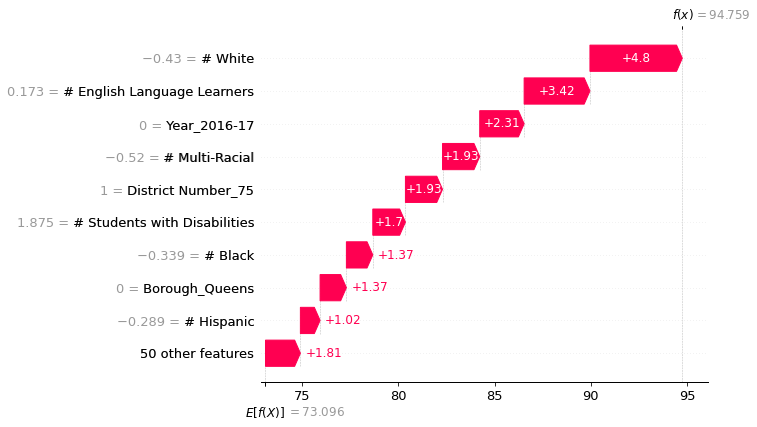

In [78]:
import shap

cat = CatBoostRegressor(learning_rate= 0.1596297433219325, n_estimators= 402, depth= 6, l2_leaf_reg= 8)
cat.fit(final_df_x_train, y_train)

explainer = shap.Explainer(cat)
shap_values = explainer(final_df_x_train)

shap.plots.waterfall(shap_values[0])

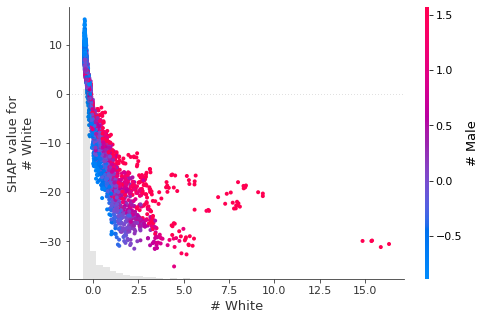

In [79]:
shap.plots.scatter(shap_values[:,'# White'], color=shap_values)
plt.savefig('/users/taehyun/Dropbox/Springboard/NYC_Capstone_project/NewYorkCity_Education/image/feature_SHAP.jpeg',bbox_inches='tight')


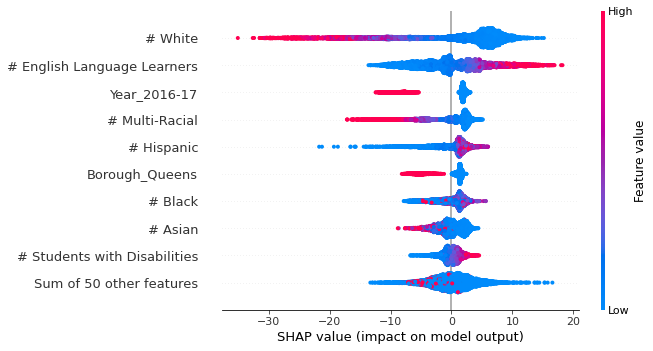

In [80]:
shap.plots.beeswarm(shap_values)

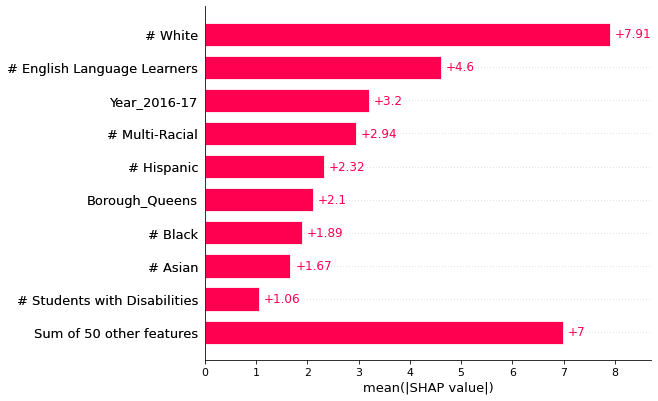

In [81]:
shap.plots.bar(shap_values)

### Choosing the right model.

CatBoost is the best model with RMSE score of 4.443611.

• Validation set RMSE score: 3.55
• Test set RMSE score: 4.44

With this highly accuracte model, we can predict the economic index by the corresponding values borough,grade,race in New York City. The mae would be 4.86 which is highly accurate. 

## Making adjustments of the results.

In [111]:
df_bronx = nyc_pandas[nyc_pandas['Borough'] == 'Bronx'].mean().reset_index().rename(columns = {'index':'index',0:'val'})

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [112]:
Staten_Island_bronx = nyc_pandas[nyc_pandas['Borough'] == 'Staten Island'].mean().reset_index().rename(columns = {'index':'index',0:'val'})

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


FixedFormatter should only be used together with FixedLocator


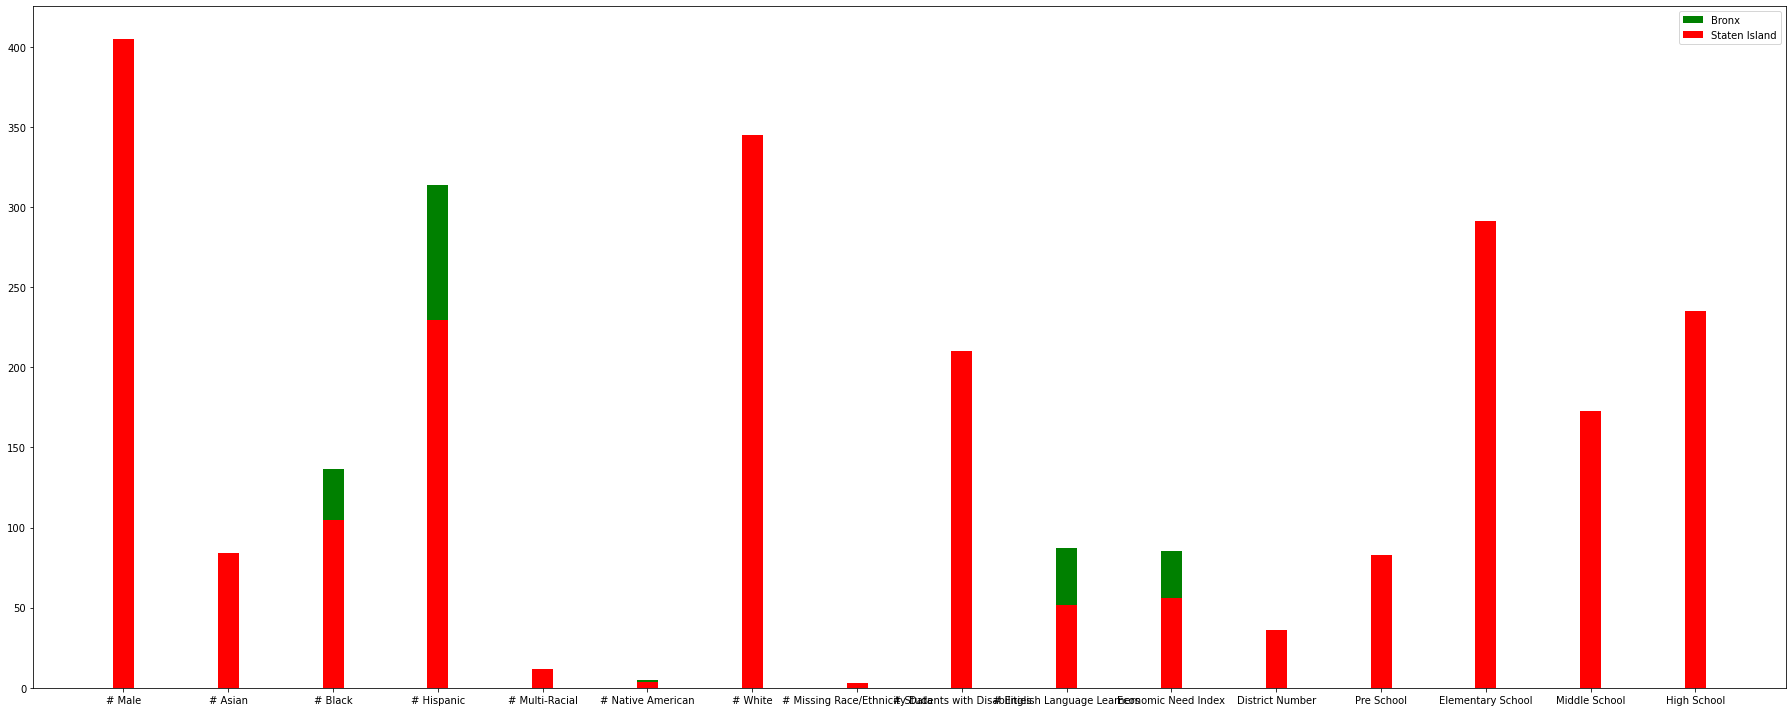

In [192]:
plt.figure(figsize=(25,10))
ax = plt.subplot(111)
width = 0.27
len_xaxis = len(Staten_Island_bronx['index'])

rects = ax.bar(df_bronx['index'], df_bronx['val'], width = 0.2, color = 'g')
rects2 = ax.bar(Staten_Island_bronx['index'], Staten_Island_bronx['val'], width = 0.2, color = 'r')

ax.legend(['Bronx','Staten Island'])
ax.set_xticklabels((Staten_Island_bronx['index']))
ax.set_xticks(rotation = 'vertical')

plt.tight_layout()
plt.savefig('/users/taehyun/Dropbox/Springboard/NYC_Capstone_project/NewYorkCity_Education/image/Solution_bar.jpeg',bbox_inches='tight')


According to the graph, Bronx has 4 features that are different with State Island. Staten Island has the last economic Need Index which is 55 and the Bronx has most economic Nddex Index with 85. Therefore, we can make several assumtpions through this graph. 

If we reduce the number of Hispanic, Black, and English Language Learner in Bronx, would the economic need index decrease as well? 

To experiment this, we will use the x_test data and modify the amount of hispanic people, black people, and englush language learners in Bronx and see how theoretically decreaseing these features will influence the economic need index 

In [298]:
print("Mean value of white people in bronx:",final_df_x_test[final_df_x_test['Borough_Bronx']==1.0]['# White'].mean())

Mean value of white people in bronx: -0.3478678077578059


In [303]:
print("Mean value of economic need index in bronx:", cat.predict(final_df_x_test[final_df_x_test['Borough_Bronx']==1.0]).mean())

Mean value of economic need index in bronx: 84.09009758268968


# Case 1. If we increase the population of white:

In [368]:
def adjust(data):
    return data + 0.3

bronx_df = final_df_x_test[final_df_x_test['Borough_Bronx']==1.0]
bronx_df.shape

(436, 59)

In [369]:
bronx_df['# White'] = bronx_df['# White'].apply(adjust)

bronx_df.shape


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(436, 59)

In [370]:
print("Mean value of white people in bronx:",bronx_df[bronx_df['Borough_Bronx']==1.0]['# White'].mean())

Mean value of white people in bronx: -0.047867807757806496


In [371]:
print("mean value of economic need index after adjusting the scale for white people:", cat.predict(bronx_df[bronx_df['Borough_Bronx']==1.0]).mean())

mean value of economic need index after adjusting the scale for white people: 77.16624326511734


In [452]:
0.8409009758268968 -  0.7716624326511734

0.06923854317572342

decreased economic need index by 0.069

When we increase the amount of white people by scale of 0.3 in the given condition mean = 0 and std = 1, Economic Need Index will decrease meaning higher graduation rate of that school and the average poverty rate will decrease.

# Case 2: Reduce Black and Hispanic people in Bronx.

In [419]:
def reduce(data, x):
    return data - x

bronx_df = final_df_x_test[final_df_x_test['Borough_Bronx']==1.0]
print("Average black people before reducing number of black people", bronx_df['# Black'].mean())

Average black people before reducing number of black people -0.10542368093441652


In [431]:
dic = {}

for i in np.arange(0.1,2.0,0.05):
    bronx_df['# Black'] = bronx_df['# Black'].apply(reduce, x = i)
    dic[i] = cat.predict(bronx_df[bronx_df['Borough_Bronx']==1.0]).mean()
    
dic


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{0.1: 82.59611707986514,
 0.15000000000000002: 82.59611707986514,
 0.20000000000000004: 82.59611707986514,
 0.25000000000000006: 82.59611707986514,
 0.30000000000000004: 82.59611707986514,
 0.3500000000000001: 82.59611707986514,
 0.40000000000000013: 82.59611707986514,
 0.45000000000000007: 82.59611707986514,
 0.5000000000000001: 82.59611707986514,
 0.5500000000000002: 82.59611707986514,
 0.6000000000000002: 82.59611707986514,
 0.6500000000000001: 82.59611707986514,
 0.7000000000000002: 82.59611707986514,
 0.7500000000000002: 82.59611707986514,
 0.8000000000000002: 82.59611707986514,
 0.8500000000000002: 82.59611707986514,
 0.9000000000000002: 82.59611707986514,
 0.9500000000000003: 82.59611707986514,
 1.0000000000000004: 82.59611707986514,
 1.0500000000000003: 82.59611707986514,
 1.1000000000000005: 82.59611707986514,
 1.1500000000000004: 82.59611707986514,
 1.2000000000000004: 82.59611707986514,
 1.2500000000000004: 82.59611707986514,
 1.3000000000000005: 82.59611707986514,
 1.350000

no matter how much we reduce the number of black people, the economic need index stays the same

In [432]:
bronx_df['# Black'] = bronx_df['# Black'].apply(reduce, x = 0.4)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [433]:
print("Average black people after reducing number of black people", bronx_df['# Black'].mean())

Average black people after reducing number of black people -106.00542368093441


In [434]:
print("mean value of economic need index after cutting off 0.3 black people:", cat.predict(bronx_df[bronx_df['Borough_Bronx']==1.0]).mean())


mean value of economic need index after cutting off 0.3 black people: 82.59611707986514


In [451]:
0.8409009758268968 -  0.8259611707986514

0.014939805028245434

Decreased the econominc need index by 0.015 by decreasing the number of black people

In [449]:
def reduce(data, x):
    return data - x

bronx_df = final_df_x_test[final_df_x_test['Borough_Bronx']==1.0]
print("Average Hispanic people before reducing number of Hispanic people", bronx_df['# Hispanic'].mean())
print("mean value of economic need index after adjusting the scale for white people:", cat.predict(bronx_df[bronx_df['Borough_Bronx']==1.0]).mean())

Average Hispanic people before reducing number of Hispanic people 0.37157377881720105
mean value of economic need index after adjusting the scale for white people: 84.09009758268968


In [450]:
dic = {}

for i in np.arange(0.1,2.0,0.05):
    bronx_df['# Hispanic'] = bronx_df['# Hispanic'].apply(reduce, x = i)
    dic[i] = cat.predict(bronx_df[bronx_df['Borough_Bronx']==1.0]).mean()
    
dic


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{0.1: 83.97881802829602,
 0.15000000000000002: 83.74514104543354,
 0.20000000000000004: 83.09579180735318,
 0.25000000000000006: 81.90435766286845,
 0.30000000000000004: 80.18494293927047,
 0.3500000000000001: 78.26537993132507,
 0.40000000000000013: 76.80184395997793,
 0.45000000000000007: 75.83568399597328,
 0.5000000000000001: 75.25968284777994,
 0.5500000000000002: 74.89757243926496,
 0.6000000000000002: 74.67255491765647,
 0.6500000000000001: 74.61998907921837,
 0.7000000000000002: 74.61391236665125,
 0.7500000000000002: 74.59173990577766,
 0.8000000000000002: 74.52169434140932,
 0.8500000000000002: 74.52169434140932,
 0.9000000000000002: 74.52169434140932,
 0.9500000000000003: 74.52169434140932,
 1.0000000000000004: 74.52169434140932,
 1.0500000000000003: 74.52169434140932,
 1.1000000000000005: 74.52169434140932,
 1.1500000000000004: 74.52169434140932,
 1.2000000000000004: 74.52169434140932,
 1.2500000000000004: 74.52169434140932,
 1.3000000000000005: 74.52169434140932,
 1.350000

In [453]:
0.84-0.74

0.09999999999999998

The more value that is subtracted by 0.5, the more ineffective it is. Therefore we should set the x as 0.5 and will return a result with a decrease of 0.1 economic need index

# Case 3: Reduce English Learners in Bronx

Now let's see if the amount of english learners in Bronx actually influences the economic need index

In [465]:
bronx_df = final_df_x_test[final_df_x_test['Borough_Bronx']==1.0]
print("Average black people before reducing number of black people", bronx_df['# English Language Learners'].mean())
print("Average Economic Need Index of people in Bronx:", cat.predict(bronx_df).mean())


Average black people before reducing number of black people 0.0681912997351013
Average Economic Need Index of people in Bronx: 84.09009758268968


In [466]:
def reduce_english(data, x):
    return data - x

dic = {}

for i in np.arange(0.1,1.0,0.01):
    bronx_df['# English Language Learners'] = bronx_df['# English Language Learners'].apply(reduce_english, x = i)
    dic[i] = cat.predict(bronx_df[bronx_df['Borough_Bronx']==1.0]).mean()
    
dic


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{0.1: 82.97542594357314,
 0.11: 81.70571984113415,
 0.12: 80.44098465164029,
 0.13: 79.23182084470672,
 0.13999999999999999: 78.33544667883449,
 0.14999999999999997: 77.51351272422978,
 0.15999999999999998: 76.95835839175338,
 0.16999999999999998: 76.62256440596948,
 0.17999999999999997: 76.28817060642399,
 0.18999999999999995: 76.07167961569922,
 0.19999999999999996: 75.88200926551406,
 0.20999999999999996: 75.62631466974342,
 0.21999999999999995: 75.38088116994003,
 0.22999999999999995: 75.10808946527351,
 0.23999999999999994: 75.00167251517813,
 0.24999999999999992: 74.93236725737496,
 0.2599999999999999: 74.8758228965818,
 0.2699999999999999: 74.82988319676546,
 0.2799999999999999: 74.7813077552297,
 0.2899999999999999: 74.77709563654014,
 0.29999999999999993: 74.76433997646986,
 0.30999999999999994: 74.74938779339917,
 0.3199999999999999: 74.72913327562816,
 0.32999999999999985: 74.71839192290722,
 0.33999999999999986: 74.71839192290722,
 0.34999999999999987: 74.71839192290722,
 0

From decreasing the economic need index from 84 to 76 by decreasing the scale of # English Learners by 0.15, the economic need index decreased by 0.08.

The main goal of this project was to build a predictive regression model that can predict the economc need index and make conclusions to inform the results to NYC.

3 possible solutions which can help decrease the economic need index. 

By increasing the white population by 0.1 in the given condition where mean = 0 and std = 1, there was a decrease in economic need index by 0.069

1. Increase the number of white people

By decreasing the black population by 0.3 in the given condition where mean = 0 and std = 1, there was a decrease in economic need index by 0.015

2. Decrease the number of black and hispanic people

By decreasing the hispanic population by 0.15 in the given condition where mean = 0 and std = 1, there was a decrease in economic need index by 0.1

3. Decrease the number of english learners

By decreasing the english learners by 0.2 in the given condition where mean = 0 and std = 1, there was a decrease in economic need index by 0.08